# 팀과제: Santa vs 일반인 이미지 분류 (VGG19 직접 구현 & 전이학습)


- VGG19 아키텍처 직접 구현 (Conv+ReLU / MaxPool / FC)
- 전이학습: ImageNet 가중치(state_dict)만 로드해서 우리 구현 모델에 적용
- 비교 필수 지표: Accuracy / Loss / 학습 속도(초/epoch) 비교, 그래프 출력

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

# =========================
# 기본 세팅
# =========================
import os, time, copy, random, zipfile
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


## 1) 데이터 준비 (santa.zip 자동 압축해제)

In [ ]:

# =========================
# santa.zip -> dataset 폴더로 압축해제
# =========================
ZIP_PATH = "/content/drive/MyDrive/랭체인 AI 영상객체탐지분석 플랫폼 구축/data/santa.zip"
EXTRACT_DIR = "./dataset"

def ensure_dataset(zip_path=ZIP_PATH, extract_dir=EXTRACT_DIR):
    need = ["train", "val", "test"]
    if os.path.isdir(extract_dir) and all(os.path.isdir(os.path.join(extract_dir, x)) for x in need):
        print(f"[OK] dataset 폴더가 이미 존재합니다: {extract_dir}")
        return extract_dir

    if not os.path.exists(zip_path):
        raise FileNotFoundError(
            f"{zip_path} 를 찾을 수 없습니다. Colab에 업로드하거나 경로를 수정하세요."
        )

    os.makedirs(extract_dir, exist_ok=True)
    with zipfile.ZipFile(zip_path, "r") as z:
        z.extractall(".")

    if all(os.path.isdir(x) for x in ["train","val","test"]):
        for split in ["train","val","test"]:
            target = os.path.join(extract_dir, split)
            if os.path.exists(target):
                continue
            os.rename(split, target)

    print(f"[OK] 압축해제 완료: {extract_dir}")
    return extract_dir

DATA_ROOT = ensure_dataset()
print("DATA_ROOT =", DATA_ROOT)


[OK] 압축해제 완료: ./dataset
DATA_ROOT = ./dataset


In [ ]:

# =========================
# DataLoader 구성
# =========================
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = 2

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

train_tf = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

eval_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

train_ds = datasets.ImageFolder(os.path.join(DATA_ROOT, "train"), transform=train_tf)
val_ds   = datasets.ImageFolder(os.path.join(DATA_ROOT, "val"),   transform=eval_tf)
test_ds  = datasets.ImageFolder(os.path.join(DATA_ROOT, "test"),  transform=eval_tf)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

class_names = train_ds.classes
num_classes = len(class_names)
print("Classes:", class_names, "num_classes:", num_classes)

from collections import Counter
def count_per_class(ds):
    c = Counter([ds.samples[i][1] for i in range(len(ds))])
    return {class_names[k]: v for k,v in c.items()}

print("Train:", count_per_class(train_ds))
print("Val  :", count_per_class(val_ds))
print("Test :", count_per_class(test_ds))


Classes: ['normal', 'santa'] num_classes: 2
Train: {'normal': 449, 'santa': 446}
Val  : {'normal': 134, 'santa': 133}
Test : {'normal': 32, 'santa': 36}


## 2) VGG19 직접 구현

VGG19 구성:
- Convolution blocks: (2-2-4-4-4) conv layers
- MaxPooling: 5회
- Classifier: 4096 → 4096 → num_classes

In [ ]:

# =========================
# VGG19 직접 구현
# =========================
def make_vgg19_features():
    # VGG19 config:
    # [64,64,'M', 128,128,'M', 256,256,256,256,'M', 512,512,512,512,'M', 512,512,512,512,'M']
    cfg = [64, 64, "M",
           128, 128, "M",
           256, 256, 256, 256, "M",
           512, 512, 512, 512, "M",
           512, 512, 512, 512, "M"]
    layers = []
    in_ch = 3
    for v in cfg:
        if v == "M":
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        else:
            layers.append(nn.Conv2d(in_ch, v, kernel_size=3, padding=1))
            layers.append(nn.ReLU(inplace=True))
            in_ch = v
    return nn.Sequential(*layers)

class VGG19(nn.Module):
    def __init__(self, num_classes=2, init_weights=True, dropout=0.5):
        super().__init__()
        self.features = make_vgg19_features()
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512*7*7, 4096),
            nn.ReLU(True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

def count_params(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

# sanity check
m = VGG19(num_classes=num_classes).to(device)
with torch.no_grad():
    y = m(torch.randn(2,3,224,224).to(device))
print("Sanity output shape:", y.shape)
print("Params (total/trainable):", count_params(m))


Sanity output shape: torch.Size([2, 2])
Params (total/trainable): (139578434, 139578434)


## 3) 학습/평가 루프 + 속도 측정

In [ ]:

# =========================
# Train / Eval / Plot (speed 포함)
# =========================
@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    loss_sum, correct, n = 0.0, 0, 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        logits = model(imgs)
        loss = criterion(logits, labels)
        loss_sum += loss.item() * imgs.size(0)
        pred = logits.argmax(1)
        correct += (pred == labels).sum().item()
        n += imgs.size(0)
    return loss_sum / n, correct / n

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10, scheduler=None, mixed_precision=True):
    scaler = torch.cuda.amp.GradScaler(enabled=(mixed_precision and device.type=="cuda"))
    hist = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": [], "epoch_time_sec": []}
    best_wts = copy.deepcopy(model.state_dict())
    best_val_acc = 0.0

    for epoch in range(1, epochs+1):
        if device.type == "cuda":
            torch.cuda.synchronize()
        t0 = time.perf_counter()

        model.train()
        loss_sum, correct, n = 0.0, 0, 0

        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad(set_to_none=True)

            with torch.cuda.amp.autocast(enabled=(mixed_precision and device.type=="cuda")):
                logits = model(imgs)
                loss = criterion(logits, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            loss_sum += loss.item() * imgs.size(0)
            pred = logits.argmax(1)
            correct += (pred == labels).sum().item()
            n += imgs.size(0)

        train_loss = loss_sum / n
        train_acc = correct / n

        val_loss, val_acc = evaluate(model, val_loader, criterion)

        if scheduler is not None:
            scheduler.step()

        if device.type == "cuda":
            torch.cuda.synchronize()
        t1 = time.perf_counter()
        dt = t1 - t0

        hist["train_loss"].append(train_loss)
        hist["train_acc"].append(train_acc)
        hist["val_loss"].append(val_loss)
        hist["val_acc"].append(val_acc)
        hist["epoch_time_sec"].append(dt)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_wts = copy.deepcopy(model.state_dict())

        print(f"[{epoch:02d}/{epochs}] "
              f"train_loss={train_loss:.4f} train_acc={train_acc:.4f} | "
              f"val_loss={val_loss:.4f} val_acc={val_acc:.4f} | "
              f"time={dt:.1f}s")

    model.load_state_dict(best_wts)
    return model, hist

def plot_history(hist, title=""):
    e = range(1, len(hist["train_loss"])+1)

    plt.figure()
    plt.plot(e, hist["train_loss"], label="train_loss")
    plt.plot(e, hist["val_loss"], label="val_loss")
    plt.title(f"{title} Loss")
    plt.xlabel("epoch"); plt.ylabel("loss"); plt.legend()
    plt.show()

    plt.figure()
    plt.plot(e, hist["train_acc"], label="train_acc")
    plt.plot(e, hist["val_acc"], label="val_acc")
    plt.title(f"{title} Accuracy")
    plt.xlabel("epoch"); plt.ylabel("acc"); plt.legend()
    plt.show()

    plt.figure()
    plt.plot(e, hist["epoch_time_sec"], label="sec/epoch")
    plt.title(f"{title} Speed")
    plt.xlabel("epoch"); plt.ylabel("seconds"); plt.legend()
    plt.show()

@torch.no_grad()
def predict_all(model, loader):
    model.eval()
    y_true, y_pred = [], []
    for imgs, labels in loader:
        imgs = imgs.to(device)
        logits = model(imgs)
        pred = logits.argmax(1).cpu().numpy().tolist()
        y_pred += pred
        y_true += labels.numpy().tolist()
    return np.array(y_true), np.array(y_pred)


## 4) VGG19 직접 구현 학습



A) VGG19 From Scratch Training
Params (total/trainable): (139578434, 139578434)


/tmp/ipython-input-2268331888.py:19: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(mixed_precision and device.type=="cuda"))
/tmp/ipython-input-2268331888.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(mixed_precision and device.type=="cuda")):


[01/10] train_loss=0.7014 train_acc=0.5464 | val_loss=0.5692 val_acc=0.6704 | time=21.1s
[02/10] train_loss=0.5715 train_acc=0.6994 | val_loss=0.5420 val_acc=0.6404 | time=22.2s
[03/10] train_loss=0.7132 train_acc=0.6380 | val_loss=0.6824 val_acc=0.5019 | time=20.8s
[04/10] train_loss=0.6422 train_acc=0.5430 | val_loss=0.5789 val_acc=0.7828 | time=22.0s
[05/10] train_loss=0.5490 train_acc=0.7352 | val_loss=0.4015 val_acc=0.8165 | time=20.5s
[06/10] train_loss=0.5050 train_acc=0.7777 | val_loss=0.5828 val_acc=0.7266 | time=21.9s
[07/10] train_loss=0.4303 train_acc=0.8034 | val_loss=0.3758 val_acc=0.8502 | time=20.8s
[08/10] train_loss=0.4121 train_acc=0.8268 | val_loss=0.2721 val_acc=0.8914 | time=21.9s
[09/10] train_loss=0.3268 train_acc=0.8626 | val_loss=0.2436 val_acc=0.8989 | time=21.0s
[10/10] train_loss=0.2846 train_acc=0.8782 | val_loss=0.2423 val_acc=0.9026 | time=21.8s


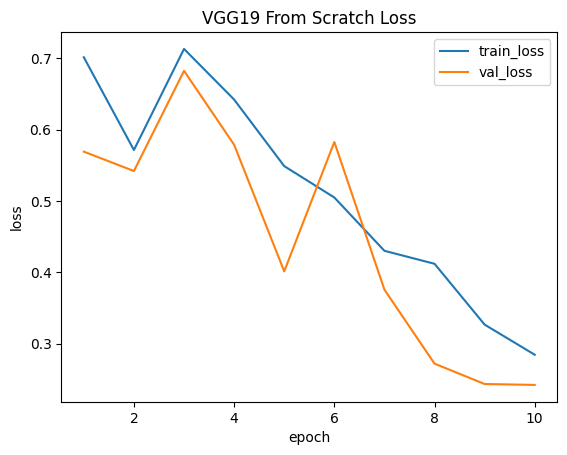

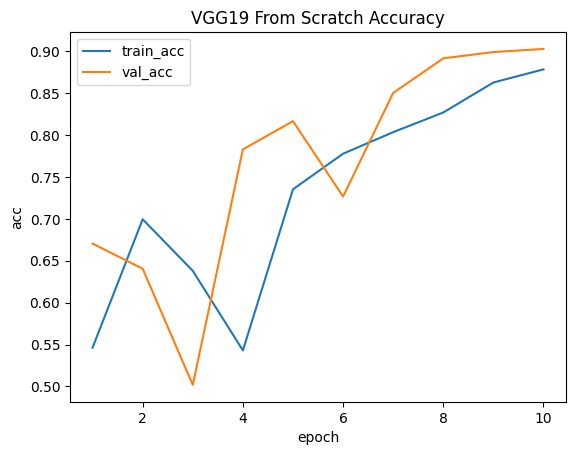

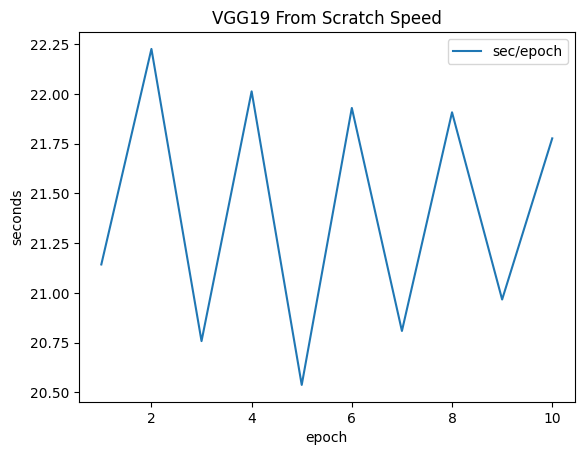


[Scratch] TEST Loss: 0.1484 TEST Acc: 0.9265

[Scratch] Confusion Matrix
 [[30  2]
 [ 3 33]]

[Scratch] Classification Report
               precision    recall  f1-score   support

      normal       0.91      0.94      0.92        32
       santa       0.94      0.92      0.93        36

    accuracy                           0.93        68
   macro avg       0.93      0.93      0.93        68
weighted avg       0.93      0.93      0.93        68



In [ ]:

# =========================
# Experiment A: From Scratch
# =========================
EPOCHS_SCRATCH = 10
lr_scratch = 1e-4

scratch_model = VGG19(num_classes=num_classes, init_weights=True).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(scratch_model.parameters(), lr=lr_scratch)

print("\n==============================")
print("A) VGG19 From Scratch Training")
print("==============================")
print("Params (total/trainable):", count_params(scratch_model))

scratch_model, scratch_hist = train_model(
    scratch_model, train_loader, val_loader,
    criterion, optimizer,
    epochs=EPOCHS_SCRATCH,
    mixed_precision=True
)

plot_history(scratch_hist, "VGG19 From Scratch")

test_loss_s, test_acc_s = evaluate(scratch_model, test_loader, criterion)
print("\n[Scratch] TEST Loss:", round(test_loss_s,4), "TEST Acc:", round(test_acc_s,4))

y_true_s, y_pred_s = predict_all(scratch_model, test_loader)
print("\n[Scratch] Confusion Matrix\n", confusion_matrix(y_true_s, y_pred_s))
print("\n[Scratch] Classification Report\n", classification_report(y_true_s, y_pred_s, target_names=class_names))


## 5) 실험 B — 전이학습 VGG19


Missing keys (expected): ['classifier.6.weight', 'classifier.6.bias']
Unexpected keys: []

B) VGG19 Transfer Learning (Frozen)
Params (total/trainable): (139578434, 119554050)


/tmp/ipython-input-2268331888.py:19: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(mixed_precision and device.type=="cuda"))
/tmp/ipython-input-2268331888.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(mixed_precision and device.type=="cuda")):


[01/10] train_loss=1.1360 train_acc=0.8335 | val_loss=0.1661 val_acc=0.9401 | time=21.0s
[02/10] train_loss=0.3117 train_acc=0.9218 | val_loss=0.2244 val_acc=0.9551 | time=19.5s
[03/10] train_loss=0.4252 train_acc=0.9453 | val_loss=0.6465 val_acc=0.9438 | time=21.3s
[04/10] train_loss=0.3387 train_acc=0.9642 | val_loss=0.5219 val_acc=0.9213 | time=19.8s
[05/10] train_loss=0.3316 train_acc=0.9687 | val_loss=0.1261 val_acc=0.9700 | time=21.3s
[06/10] train_loss=0.1620 train_acc=0.9810 | val_loss=1.3387 val_acc=0.9401 | time=20.0s
[07/10] train_loss=0.3581 train_acc=0.9799 | val_loss=0.4642 val_acc=0.9700 | time=21.0s
[08/10] train_loss=0.3237 train_acc=0.9821 | val_loss=0.9692 val_acc=0.9513 | time=20.0s
[09/10] train_loss=0.2579 train_acc=0.9832 | val_loss=2.5885 val_acc=0.9326 | time=19.7s
[10/10] train_loss=1.0991 train_acc=0.9665 | val_loss=2.7228 val_acc=0.9401 | time=21.2s


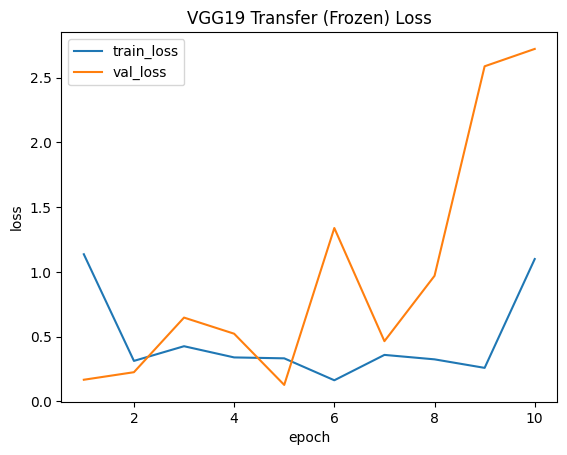

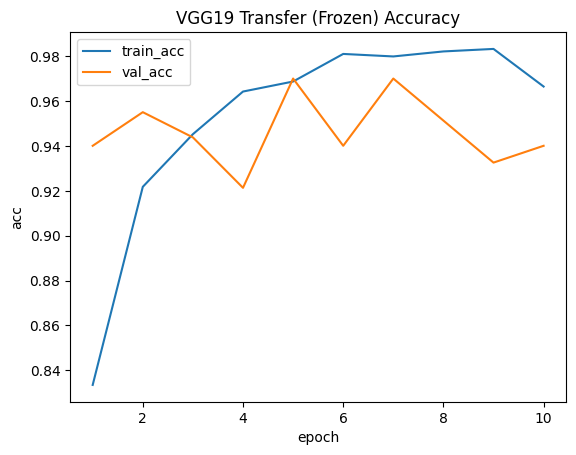

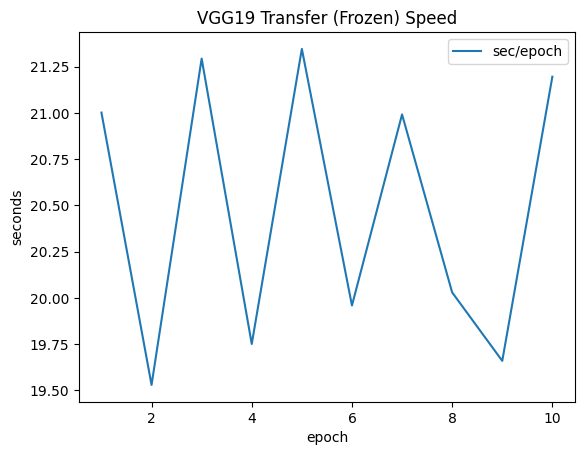


[Transfer-Frozen] TEST Loss: 0.3994 TEST Acc: 0.9853

[Transfer-Frozen] Confusion Matrix
 [[32  0]
 [ 1 35]]

[Transfer-Frozen] Classification Report
               precision    recall  f1-score   support

      normal       0.97      1.00      0.98        32
       santa       1.00      0.97      0.99        36

    accuracy                           0.99        68
   macro avg       0.98      0.99      0.99        68
weighted avg       0.99      0.99      0.99        68



In [ ]:

# =========================
# Experiment B: Transfer Learning
# =========================
VGG19_IMAGENET_URL = "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth"

from torch.hub import load_state_dict_from_url

def load_imagenet_weights(model: VGG19):
    state_dict = load_state_dict_from_url(VGG19_IMAGENET_URL, progress=True, map_location="cpu")

    for k in ["classifier.6.weight", "classifier.6.bias"]:
        if k in state_dict:
            del state_dict[k]

    missing, unexpected = model.load_state_dict(state_dict, strict=False)
    print("Missing keys (expected):", missing)
    print("Unexpected keys:", unexpected)
    return model


EPOCHS_TL = 10
lr_tl = 1e-3

tl_model = VGG19(num_classes=num_classes, init_weights=False).to(device)
tl_model = load_imagenet_weights(tl_model)

for p in tl_model.features.parameters():
    p.requires_grad = False

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, tl_model.parameters()), lr=lr_tl)

print("\n======================================")
print("B) VGG19 Transfer Learning (Frozen)")
print("======================================")
print("Params (total/trainable):", count_params(tl_model))

tl_model, tl_hist = train_model(
    tl_model, train_loader, val_loader,
    criterion, optimizer,
    epochs=EPOCHS_TL,
    mixed_precision=True
)

plot_history(tl_hist, "VGG19 Transfer (Frozen)")

test_loss_t, test_acc_t = evaluate(tl_model, test_loader, criterion)
print("\n[Transfer-Frozen] TEST Loss:", round(test_loss_t,4), "TEST Acc:", round(test_acc_t,4))

y_true_t, y_pred_t = predict_all(tl_model, test_loader)
print("\n[Transfer-Frozen] Confusion Matrix\n", confusion_matrix(y_true_t, y_pred_t))
print("\n[Transfer-Frozen] Classification Report\n", classification_report(y_true_t, y_pred_t, target_names=class_names))


### Fine-tuning



B-2) Fine-Tuning (Partial Unfreeze)
Params (total/trainable): (139578434, 137252866)


/tmp/ipython-input-2268331888.py:19: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(mixed_precision and device.type=="cuda"))
/tmp/ipython-input-2268331888.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(mixed_precision and device.type=="cuda")):


[01/3] train_loss=0.1862 train_acc=0.9732 | val_loss=0.2123 val_acc=0.9738 | time=21.6s
[02/3] train_loss=0.0251 train_acc=0.9933 | val_loss=0.1057 val_acc=0.9850 | time=20.1s
[03/3] train_loss=0.0100 train_acc=0.9966 | val_loss=0.1109 val_acc=0.9850 | time=20.7s


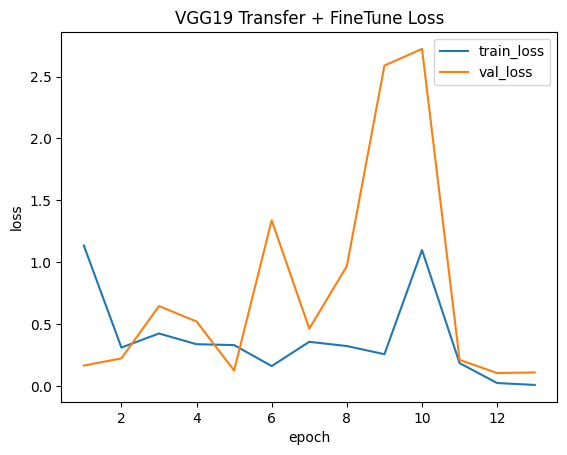

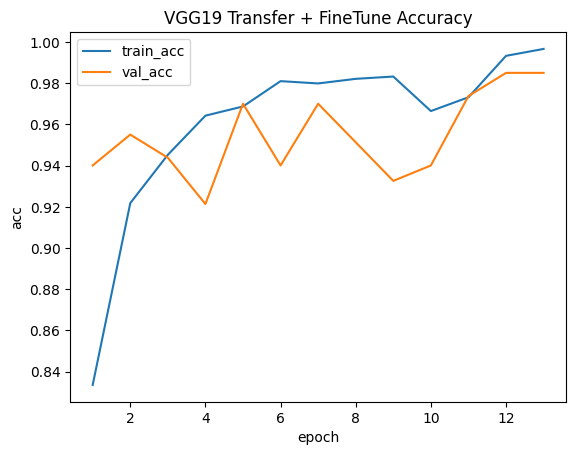

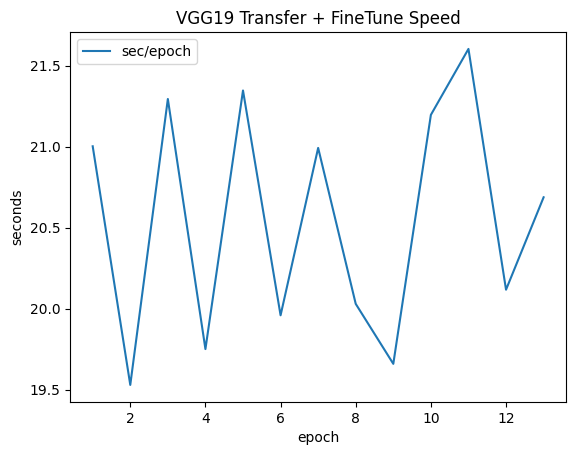


[Transfer+FineTune] TEST Loss: 0.2526 TEST Acc: 0.9853

[Transfer+FineTune] Confusion Matrix
 [[32  0]
 [ 1 35]]

[Transfer+FineTune] Classification Report
               precision    recall  f1-score   support

      normal       0.97      1.00      0.98        32
       santa       1.00      0.97      0.99        36

    accuracy                           0.99        68
   macro avg       0.98      0.99      0.99        68
weighted avg       0.99      0.99      0.99        68



In [ ]:

# =========================
# Optional Fine-tuning
# =========================
DO_FINE_TUNE = True

if DO_FINE_TUNE:
    FINE_TUNE_EPOCHS = 3
    lr_ft = 1e-5

    params = list(tl_model.features.parameters())
    for p in params:
        p.requires_grad = False
    for p in params[-16:]:
        p.requires_grad = True

    optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, tl_model.parameters()), lr=lr_ft)

    print("\n======================================")
    print("B-2) Fine-Tuning (Partial Unfreeze)")
    print("======================================")
    print("Params (total/trainable):", count_params(tl_model))

    tl_model, ft_hist = train_model(
        tl_model, train_loader, val_loader,
        criterion, optimizer_ft,
        epochs=FINE_TUNE_EPOCHS,
        mixed_precision=True
    )

    tl_hist_all = {k: tl_hist[k] + ft_hist[k] for k in tl_hist.keys()}
    plot_history(tl_hist_all, "VGG19 Transfer + FineTune")

    test_loss_tf, test_acc_tf = evaluate(tl_model, test_loader, criterion)
    print("\n[Transfer+FineTune] TEST Loss:", round(test_loss_tf,4), "TEST Acc:", round(test_acc_tf,4))

    y_true_tf, y_pred_tf = predict_all(tl_model, test_loader)
    print("\n[Transfer+FineTune] Confusion Matrix\n", confusion_matrix(y_true_tf, y_pred_tf))
    print("\n[Transfer+FineTune] Classification Report\n", classification_report(y_true_tf, y_pred_tf, target_names=class_names))
else:
    tl_hist_all = None
    test_loss_tf, test_acc_tf = None, None


## 6) 비교 표 (Accuracy / Loss / Speed)


In [11]:

import pandas as pd

def summarize(name, hist, test_loss, test_acc):
    return {
        "name": name,
        "best_val_acc": float(np.max(hist["val_acc"])),
        "final_val_acc": float(hist["val_acc"][-1]),
        "test_acc": float(test_acc),
        "test_loss": float(test_loss),
        "avg_sec_per_epoch": float(np.mean(hist["epoch_time_sec"])),
        "total_train_sec": float(np.sum(hist["epoch_time_sec"])),
    }

rows = []
rows.append(summarize("Scratch VGG19", scratch_hist, test_loss_s, test_acc_s))
rows.append(summarize("Transfer VGG19 (Frozen)", tl_hist, test_loss_t, test_acc_t))
if DO_FINE_TUNE:
    rows.append(summarize("Transfer VGG19 + FineTune", tl_hist_all, test_loss_tf, test_acc_tf))

df = pd.DataFrame(rows)
df


,name,best_val_acc,final_val_acc,test_acc,test_loss,avg_sec_per_epoch,total_train_sec
0,Scratch VGG19,0.902622,0.902622,0.926471,0.148351,21.406178,214.061775
1,Transfer VGG19 (Frozen),0.970037,0.940075,0.985294,0.399359,20.475694,204.756938
2,Transfer VGG19 + FineTune,0.985019,0.985019,0.985294,0.252574,20.551026,267.163339


## 7) 분석 정리

- Scratch가 느리고 성능이 낮게 시작하는 이유: 랜덤 초기화 → low-level feature(엣지/텍스처)부터 학습 필요  
- Transfer가 빠르게 성능이 오르는 이유: ImageNet에서 학습한 feature 재사용 → 적은 데이터에서도 빠르게 수렴  
- 속도 차이(특히 Frozen): 업데이트되는 파라미터 수가 줄어 backprop 연산량 감소